#library

In [ ]:
!pip install datasets

In [ ]:
import torch
import time
import os
import numpy as np
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

#download dataset

In [ ]:

# مسیر دلخواه برای ذخیره‌سازی داده‌ها
save_path = "/content/mnist"

# اطمینان از اینکه پوشه وجود دارد
os.makedirs(save_path, exist_ok=True)

# دانلود و ذخیره دیتاست در مسیر مشخص‌شده
ds = load_dataset("ylecun/mnist", cache_dir=save_path)

# چاپ مسیر ذخیره‌شده
print(f"Dataset downloaded and cached at: {save_path}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset downloaded and cached at: /content/mnist


#Creation valid data

In [ ]:

# دسترسی به داده‌های train
train_data = ds['train']

# تبدیل داده‌ها به لیست برای تقسیم‌بندی
train_examples = train_data['image']  # تصاویر
train_labels = train_data['label']    # برچسب‌ها

# تقسیم داده‌ها به آموزش و اعتبارسنجی
train_images, val_images, train_labels, val_labels = train_test_split(
    train_examples, train_labels, test_size=0.2, random_state=42  # 20% برای اعتبارسنجی
)

# چاپ نتایج تقسیم
print(f"تعداد داده‌های آموزش: {len(train_images)}")
print(f"تعداد داده‌های اعتبارسنجی: {len(val_images)}")


تعداد داده‌های آموزش: 48000
تعداد داده‌های اعتبارسنجی: 12000


#Simple CNN

Epoch 1/5, Train Loss: 0.1714, Val Loss: 0.0582, Accuracy: 98.14%
Epoch 2/5, Train Loss: 0.0485, Val Loss: 0.0441, Accuracy: 98.54%
Epoch 3/5, Train Loss: 0.0293, Val Loss: 0.0492, Accuracy: 98.52%
Epoch 4/5, Train Loss: 0.0194, Val Loss: 0.0419, Accuracy: 98.75%
Epoch 5/5, Train Loss: 0.0144, Val Loss: 0.0425, Accuracy: 99.01%
Training completed in 833.25 seconds.


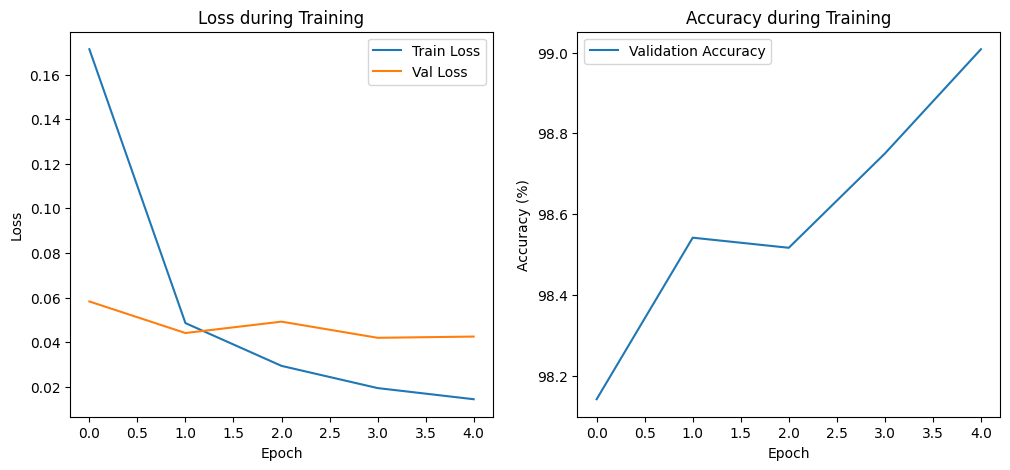

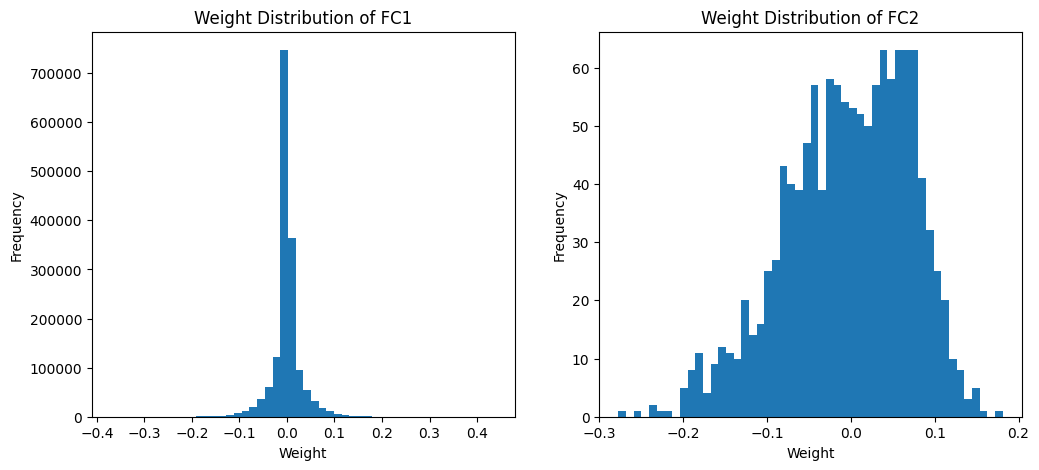

In [ ]:

# تبدیل داده‌ها به قالب PyTorch Dataset
class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = [np.array(img) for img in images]  # تبدیل تصاویر به numpy
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0  # نرمال‌سازی
        label = torch.tensor(label, dtype=torch.long)
        return image, label

# ساخت دیتاست‌های آموزش و اعتبارسنجی
train_dataset = MNISTDataset(train_images, train_labels)
val_dataset = MNISTDataset(val_images, val_labels)

# بارگذاری داده‌ها
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        # محاسبه تعداد ویژگی‌های ورودی به لایه خطی
        self._to_linear = None
        self.calculate_linear_input()

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 10)

    def calculate_linear_input(self):
        # عبور یک ورودی تصادفی از شبکه برای محاسبه ابعاد خروجی
        with torch.no_grad():
            x = torch.rand(1, 1, 28, 28)  # ورودی MNIST: 1 کانال، 28x28
            x = self.relu(self.conv1(x))
            x = self.pool(self.relu(self.conv2(x)))
            self._to_linear = x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # تغییر ابعاد برای ورودی به لایه خطی
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# مدل، تابع هزینه و بهینه‌ساز
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# آموزش مدل
num_epochs = 5
train_losses, val_losses, accuracies = [], [], []
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # ارزیابی روی داده‌های اعتبارسنجی
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    accuracies.append(100 * correct / total)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Accuracy: {accuracies[-1]:.2f}%")

end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds.")

# رسم تغییرات Loss و Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy during Training')
plt.legend()

plt.show()

# نمایش توزیع وزن‌های دو لایه آخر
def plot_weight_distribution(layer, title):
    weights = layer.weight.data.cpu().numpy().flatten()
    plt.hist(weights, bins=50)
    plt.title(title)
    plt.xlabel('Weight')
    plt.ylabel('Frequency')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_weight_distribution(model.fc1, 'Weight Distribution of FC1')
plt.subplot(1, 2, 2)
plot_weight_distribution(model.fc2, 'Weight Distribution of FC2')
plt.show()


In [ ]:
test_data = ds['test']
test_images = test_data['image']
test_labels = test_data['label']

# تبدیل داده‌ها به PyTorch Dataset
test_dataset = MNISTDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ارزیابی مدل روی داده‌های تست
model.eval()  # تغییر حالت مدل به حالت ارزیابی
correct = 0
total = 0
test_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# محاسبه دقت
accuracy = 100 * correct / total
average_test_loss = test_loss / len(test_loader)

print(f"Test Loss: {average_test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")


Test Loss: 0.0533
Test Accuracy: 98.45%


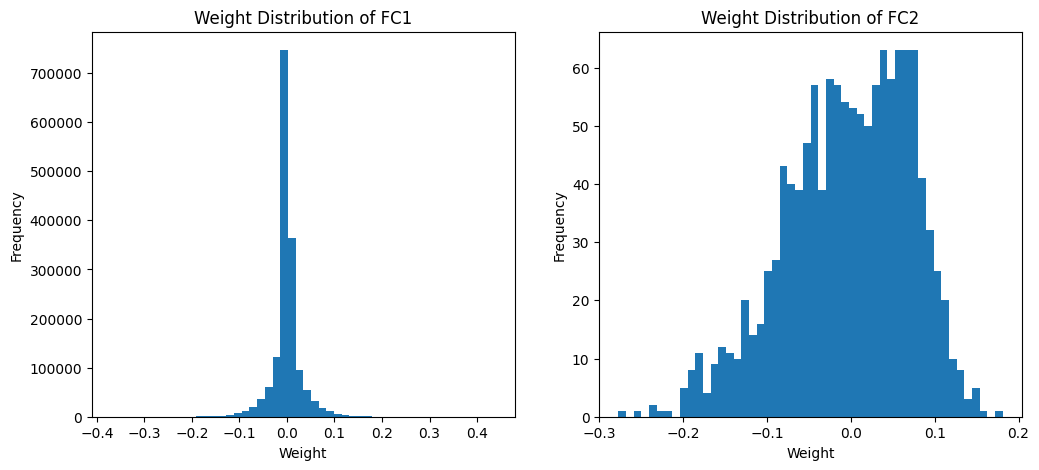

In [ ]:
# رسم توزیع وزن‌های دو لایه آخر برای مدل SimpleCNN
def plot_weight_distribution(layer, title):
    weights = layer.weight.data.cpu().numpy().flatten()
    plt.hist(weights, bins=50)
    plt.title(title)
    plt.xlabel('Weight')
    plt.ylabel('Frequency')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_weight_distribution(model.fc1, 'Weight Distribution of FC1')
plt.subplot(1, 2, 2)
plot_weight_distribution(model.fc2, 'Weight Distribution of FC2')
plt.show()

#pretrained CNN ResNet18

In [ ]:

# تعریف transform برای تبدیل تصاویر تک‌کاناله به سه‌کاناله
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # تبدیل به 3 کانال
    transforms.ToTensor(),  # تبدیل به Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # نرمال‌سازی
])

# بارگذاری دوباره داده‌ها با تبدیل جدید
train_dataset = torch.utils.data.TensorDataset(
    torch.stack([transform(image) for image in train_images]),
    torch.tensor(train_labels)
)

val_dataset = torch.utils.data.TensorDataset(
    torch.stack([transform(image) for image in val_images]),
    torch.tensor(val_labels)
)

# ایجاد DataLoader برای داده‌های آموزشی و اعتبارسنجی
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


Epoch 1/5 - Train Loss: 0.1413 - Val Loss: 0.0516 - Train Accuracy: 98.90% - Val Accuracy: 98.67%
Epoch 2/5 - Train Loss: 0.0642 - Val Loss: 0.0606 - Train Accuracy: 98.62% - Val Accuracy: 98.46%
Epoch 3/5 - Train Loss: 0.0498 - Val Loss: 0.0397 - Train Accuracy: 99.07% - Val Accuracy: 98.87%
Epoch 4/5 - Train Loss: 0.0372 - Val Loss: 0.0346 - Train Accuracy: 99.38% - Val Accuracy: 99.07%
Epoch 5/5 - Train Loss: 0.0353 - Val Loss: 0.0398 - Train Accuracy: 99.24% - Val Accuracy: 98.88%


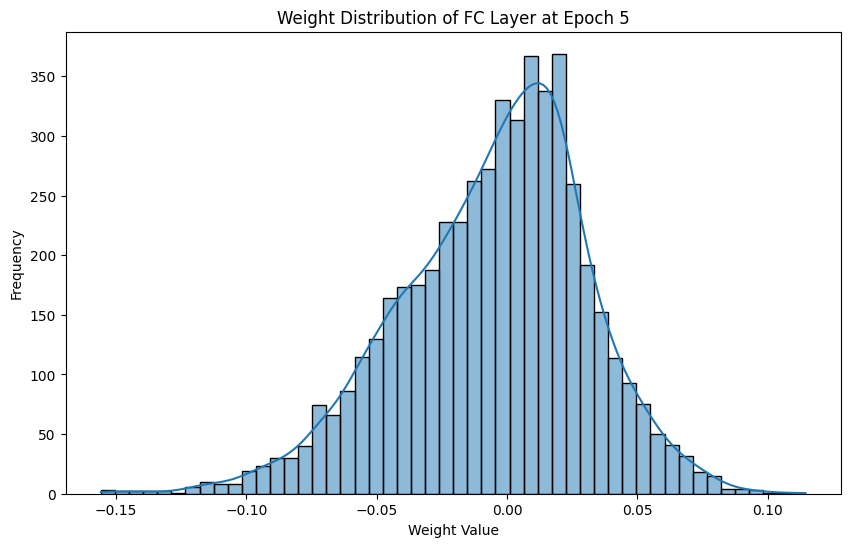

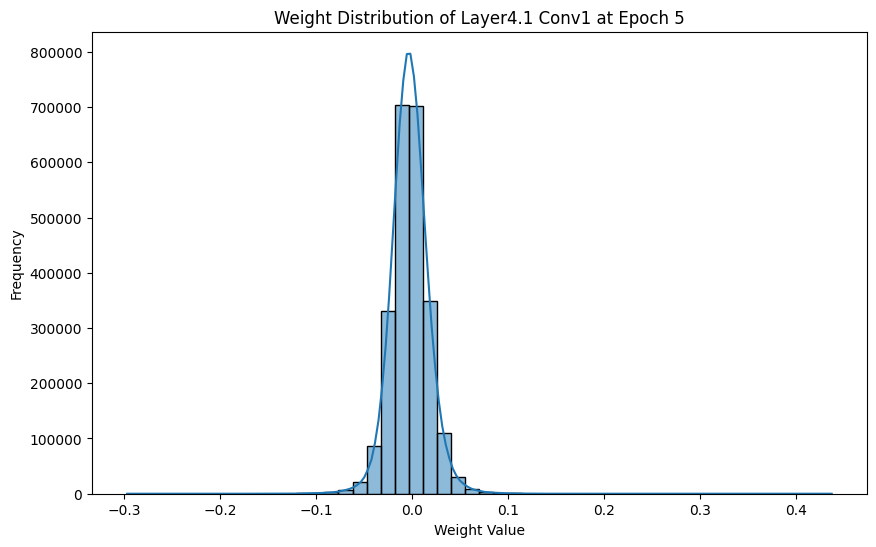

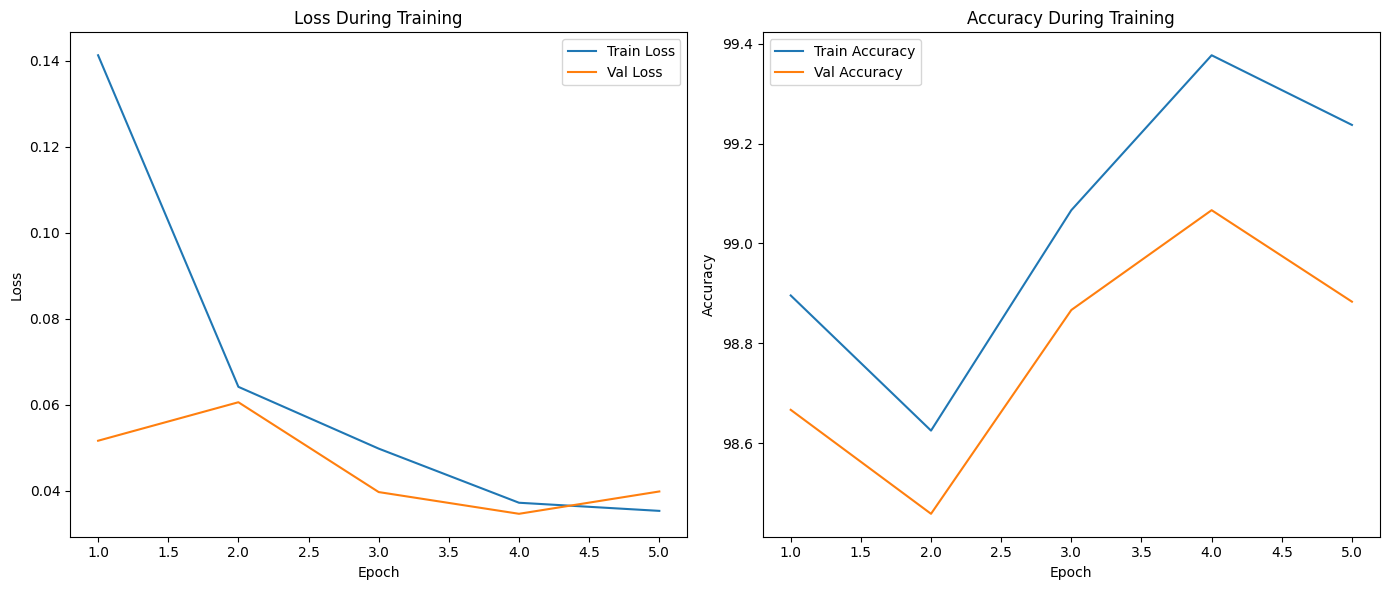

Total Training Time: 5103.23 seconds


In [ ]:

# تنظیمات دستگاه
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# بارگذاری مدل ResNet18 از پیش آموزش دیده و تغییر لایه FC
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 10)  # تغییر تعداد کلاس‌ها برای MNIST
model = model.to(device)

# تابع هزینه و بهینه‌ساز
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# تعداد ایپوک‌ها
num_epochs = 5

# ذخیره مقادیر برای رسم نمودارهای Loss و Accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# تابع برای محاسبه دقت
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# تابع برای رسم توزیع وزن‌ها
def plot_weight_distribution(model, layer_name, epoch, title=""):
    weights = model.state_dict()[layer_name].detach().cpu().numpy().flatten()
    plt.figure(figsize=(10, 6))
    sns.histplot(weights, bins=50, kde=True)
    plt.title(f'{title} at Epoch {epoch}')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.show()

# حلقه آموزش
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # محاسبه و ذخیره مقادیر Train Loss و دقت
    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    train_accuracy = calculate_accuracy(train_loader, model)
    train_accuracies.append(train_accuracy)

    # محاسبه مقادیر Val Loss و دقت
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    val_accuracy = calculate_accuracy(val_loader, model)
    val_accuracies.append(val_accuracy)

    # چاپ مقادیر در هر ایپوک
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f} - Train Accuracy: {train_accuracy:.2f}% - Val Accuracy: {val_accuracy:.2f}%')

# رسم نمودار توزیع وزن‌ها برای لایه‌های FC1 و FC2
plot_weight_distribution(model, 'fc.weight', num_epochs, title="Weight Distribution of FC Layer")
plot_weight_distribution(model, 'layer4.1.conv1.weight', num_epochs, title="Weight Distribution of Layer4.1 Conv1")

# رسم نمودارهای Loss و Accuracy در طول آموزش
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy During Training')
plt.legend()

plt.tight_layout()
plt.show()

# نمایش زمان آموزش
end_time = time.time()
training_time = end_time - start_time
print(f'Total Training Time: {training_time:.2f} seconds')


In [ ]:

test_dataset = torch.utils.data.TensorDataset(
    torch.stack([transform(image) for image in test_images]),
    torch.tensor(test_labels)
)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# ارزیابی مدل روی داده‌های تست
model.eval()  # مدل را در حالت ارزیابی قرار می‌دهیم
test_accuracy = calculate_accuracy(test_loader, model)

# محاسبه Test Loss
running_test_loss = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()

test_loss = running_test_loss / len(test_loader)

# چاپ نتایج ارزیابی
print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.0369 - Test Accuracy: 98.99%


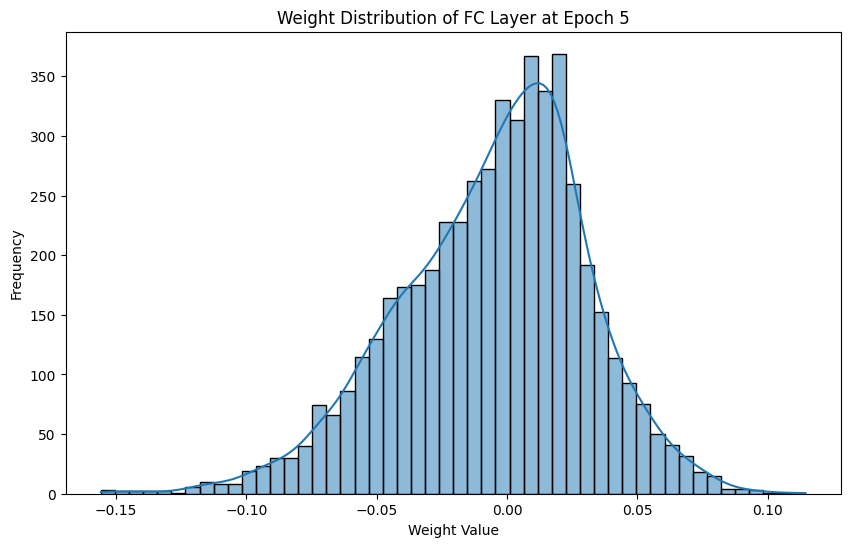

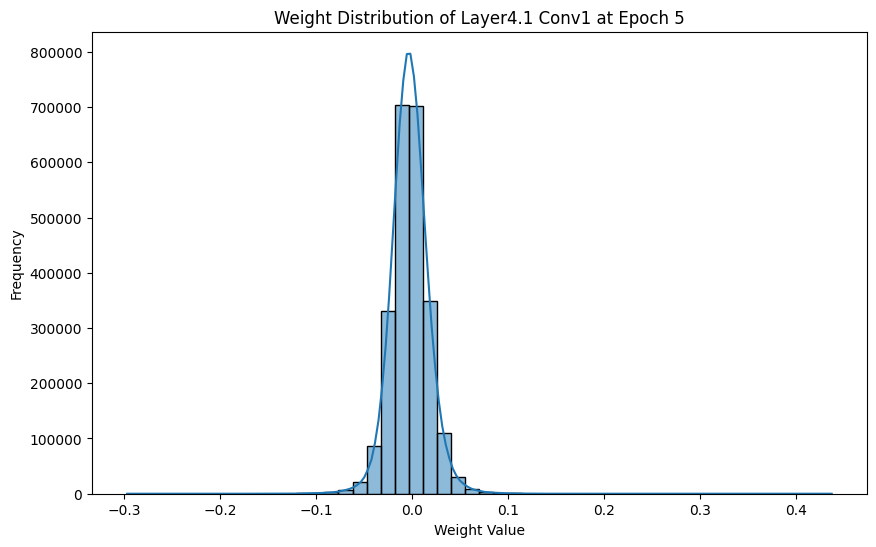

In [ ]:
# رسم توزیع وزن‌ها برای لایه‌های FC و یک لایه دیگر در ResNet18
def plot_weight_distribution(model, layer_name, epoch, title=""):
    weights = model.state_dict()[layer_name].detach().cpu().numpy().flatten()
    plt.figure(figsize=(10, 6))
    sns.histplot(weights, bins=50, kde=True)
    plt.title(f'{title} at Epoch {epoch}')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.show()

# رسم توزیع وزن‌ها برای لایه‌های FC و لایه داخلی دیگر در ResNet18
plot_weight_distribution(model, 'fc.weight', num_epochs, title="Weight Distribution of FC Layer")
plot_weight_distribution(model, 'layer4.1.conv1.weight', num_epochs, title="Weight Distribution of Layer4.1 Conv1")
